# Implementación de un modelo de deep learning. (Portafolio Implementación)

### Angel Mauricio Ramírez Herrera A01710158

---

# Resumen Breve

Este proyecto tiene como objetivo clasificar letras de canciones en su género musical correspondiente mediante NLP. Para ello, se realiza un análisis exploratorio y preprocesamiento de los datos que garantice un entrenamiento efectivo del modelo.

El dataset original contiene aproximadamente 5 millones de registros. Debido a las limitaciones computacionales del entorno gratuito de Google Colab, el entrenamiento se realizará con un subconjunto de menos de 500,000 registros.

El modelo implementado es una red neuronal recurrente LSTM (Long Short-Term Memory) que aprende patrones secuenciales en el texto. El preprocesamiento incluye limpieza de texto mediante regex, tokenización de palabras con un vocabulario de 15,000 términos, conversión a secuencias numéricas, y padding para estandarizar la longitud a 300 tokens. Se utiliza una capa de embedding de 128 capas que aprende representaciones vectoriales de las palabras durante el entrenamiento. La arquitectura LSTM de 128 capas con dropout permite capturar dependencias temporales en las letras, identificando características en la letra y temáticas distintivas de cada género musical.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import drive
from tensorflow import keras
import os

In [2]:
def get_dir_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total += os.path.getsize(fp)
    return total

def count_empty(df):
    return df.select([
        sum(when(trim(col(c)) == "", 1).otherwise(0)).alias(c)
        for c in df.columns if dict(df.dtypes)[c] == 'string'
    ])

# Extraer los datos crudos

---

El dataset utilizado contiene información recopilada durante 2022 desde la plataforma Genius, un sitio colaborativo donde los usuarios pueden subir y transcribir letras de canciones, poemas e incluso fragmentos de libros aunque su uso principal está enfocado en la música.

Este conjunto de datos incluye aproximadamente 5 millones de canciones, junto con sus respectivas letras.
Las letras provienen directamente del formato nativo de Genius, el cual requiere un preprocesamiento cuidadoso antes de ser analizado o utilizado para entrenar modelos de Deep Learning.

En particular:

- Las letras suelen incluir metadatos entre corchetes, como [Verse 1], [Chorus] o [Produced by ...], que no forman parte del contenido lírico y deben eliminarse o tratarse.

- La estructura original del texto mantiene los saltos de línea y secciones tal como aparecen en la transcripción, lo cual puede generar dificultades al leer los datos o al pasarlos a modelos que esperan texto plano.

- Además, otras columnas del dataset (como los campos de features o descripciones adicionales) también requieren limpieza y normalización antes de ser utilizadas en el pipeline de procesamiento.

In [3]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("carlosgdcj/genius-song-lyrics-with-language-information")

print("Path to dataset files:", path)

size_bytes = get_dir_size(path)
size_mb = size_bytes / (1024 * 1024)

print(f"Tamaño total de los archivos: {size_mb:.2f} MB")

Using Colab cache for faster access to the 'genius-song-lyrics-with-language-information' dataset.
Path to dataset files: /kaggle/input/genius-song-lyrics-with-language-information
Tamaño total de los archivos: 8650.20 MB


## Tamaño del Dataset

El dataset descargado ocupa 8650.20 MB (aproximadamente 8.44 GB) en disco. Aunque en Kaggle se reporta un tamaño de 9.07 GB, esta diferencia puede deberse a la compresión de archivos o a variaciones en cómo se calcula el tamaño. Con este volumen de datos, se cuenta con información suficiente para entrenar un modelo de deep learning. En este proyecto, se implementará una red neuronal recurrente basada en LSTM (Long Short Term Memory) para realizar clasificación de textos.

In [4]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

Para limitar el tamaño de los datos y optimizar el uso de recursos computacionales durante el entrenamiento y la limpieza del dataset, se seleccionaron únicamente 500,000 filas mediante el parámetro nrows=500000.

Esta reducción permite:

- Acelerar el proceso de carga, preprocesamiento y entrenamiento.
- Disminuir el uso de memoria RAM y tiempo de cómputo.
- Hacer viable el entrenamiento en Google Colab.

Sin embargo, esta decisión implica una disminución potencial en el rendimiento del modelo, ya que al disponer de menos ejemplos:

- Se reduce la diversidad y representatividad de los datos.
- El modelo puede aprender menos patrones o generalizar peor frente a datos nuevos.

In [5]:
import pandas as pd

df = pd.read_csv(
    csv_path,
    nrows=500000,
    on_bad_lines='skip',
    low_memory=False
)

## Selección de features

El dataset original contiene diversas columnas con información sobre las canciones, entre ellas:

`title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft y language.`

Se determinó que para los fines del proyecto (entrenar un modelo que clasifique las letras según su género musical) no todas las variables son necesarias.

In [6]:
df.head(10)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en
5,Lollipop Remix,rap,Lil Wayne,2008,580832,"{""Kanye West"",""Static Major""}",[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...,7,en,en,en
6,Im Not You,rap,Clipse,2002,28645,"{Jadakiss,""Styles P"",""Roscoe P. Coldchain""}","[Intro: Pusha T]\nNo, no, no!\nI told you, I l...",8,en,en,en
7,Family Ties,rap,Cam'ron,2004,41960,"{""Cam\\'ron"",""Lady Wray""}","[Verse 1: Cam'ron]\nKilla, Dipset\nMan I spit ...",9,en,en,en
8,Rockin and Rollin,rap,Cam'ron,1998,6399,"{""Cam\\'ron""}",[Verse 1]\nAy yo you wonder who I are\nI guzzl...,10,en,en,en
9,Lord You Know,rap,Cam'ron,2004,11882,"{""Cam\\'ron"",""Juelz Santana"",Jaheim}","[Chorus: Jaheim]\nNow Lord you know, just how ...",11,en,en,en


Observamos que existen un porcentaje bajo de valores nulos dentro de las 500,000 filas que seleccionamos.

In [7]:
(df.isnull().sum() / len(df) * 100).round(2).sort_values(ascending=False)

,0
language,2.41
language_ft,1.54
language_cld3,1.09
artist,0.00
tag,0.00
title,0.00
year,0.00
lyrics,0.00
features,0.00
views,0.00


El análisis de frecuencia de géneros muestra que rap es el género predominante en el dataset, seguido por misc, rock, pop, country y finalmente R&B, que presenta la menor representación.

In [8]:
df['tag'].value_counts(dropna=False)

,count
tag,
rap,248930
misc,88225
rock,77866
pop,60923
country,14399
rb,9657


La mayoría de las canciones disponibles en el dataset están en inglés, con un total de 397,486 registros en este idioma.

In [9]:
df['language'].value_counts(dropna=False)

,count
language,
en,397486
de,25660
fr,24801
NaN,12052
pl,11369
es,7685
pt,6933
it,2756
nl,1137


# Transformación de datos
---

## Filtrado por idioma

Se seleccionan únicamente las canciones cuyo idioma es inglés (language == 'en'), con el propósito de entrenar el modelo con un conjunto de datos lingüísticamente homogéneo y evitar sesgos debidos a diferencias idiomáticas.

In [10]:
filtered_df = df[df['language'] == 'en']

In [11]:
(filtered_df.isnull().sum() / len(df) * 100).round(2).sort_values(ascending=False)

,0
title,0.0
tag,0.0
artist,0.0
year,0.0
views,0.0
features,0.0
lyrics,0.0
id,0.0
language_cld3,0.0
language_ft,0.0


El ranking de los géneros más populares en las canciones se mantiene igual al filtrar el lenguaje.

In [12]:
filtered_df['tag'].value_counts(dropna=False)

,count
tag,
rap,179818
misc,77584
rock,70152
pop,46395
country,14262
rb,9275


## Selección de columnas relevantes

Dado que el obetivo es clasificar las letras (lyrics) según su género musical (tag), se conservan únicamente estas dos columnas en el dataset limpio:
- tag: género musical (etiqueta objetivo).
- lyrics: texto de la canción (característica principal para el modelo).

In [13]:
filtered_df.drop(columns=['title', 'artist', 'year', 'views', 'features', 'id', 'language_cld3', 'language_ft', 'language'], inplace=True)

/tmp/ipython-input-2747083538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(columns=['title', 'artist', 'year', 'views', 'features', 'id', 'language_cld3', 'language_ft', 'language'], inplace=True)


In [14]:
filtered_df.head(10)

,tag,lyrics
0,rap,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki..."
1,rap,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,..."
2,rap,Maybe cause I'm eatin\nAnd these bastards fien...
3,rap,[Produced by Kanye West and Brian Miller]\n\n[...
4,rap,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."
5,rap,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
6,rap,"[Intro: Pusha T]\nNo, no, no!\nI told you, I l..."
7,rap,"[Verse 1: Cam'ron]\nKilla, Dipset\nMan I spit ..."
8,rap,[Verse 1]\nAy yo you wonder who I are\nI guzzl...
9,rap,"[Chorus: Jaheim]\nNow Lord you know, just how ..."


## Limpieza de las letras

Ahora, se limpian las letras de las canciones aplicando regex para su transformación, esto nos ayuda ya que los modelos NLP funcionan mejor con texto limpio y normalizado, lo que reduce el ruido y el tamaño del vocabulario:

1. Elimina texto que se encuentra entre corchetes como [Chorus], [Verse 1]... que son metadatos dentro de la letra.
```
r'\[.*?\]'
```
2. Remplaza los saltos de linea por un espacio simple para convertir todo a una sola línea.
```
r'\n+'
```
3. Elimina todos los carácteres, excepto letras (a-z, A-Z) y espacios. Esto ayuda a remover números, signos de puntuación y carácteres especiales.
```
r'[^a-zA-Z\s]'
```
4. Compacta los espacios consecutivos en uno solo.
```
r'\s+'
```
5. Elimina los espacos en blanco al inicio y al final de cada letra.
```
.strip()
```
6. Convierte todo a minúsculas para la normalización de las palabras y tratar a todas las palabras por igual.
```
.lower()
```

In [15]:
filtered_df['lyrics_clean'] = (
    filtered_df['lyrics']
    .str.replace(r'\[.*?\]', '', regex=True)
    .str.replace(r'\n+', ' ', regex=True)
    .str.replace(r'[^a-zA-Z\s]', ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
    .str.lower()
)

/tmp/ipython-input-1229732190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['lyrics_clean'] = (


In [16]:
filtered_df.head(10)

,tag,lyrics,lyrics_clean
0,rap,"[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",killa cam killa cam cam killa cam killa cam ki...
1,rap,"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",yeah hah yeah roc a fella we invite you to som...
2,rap,Maybe cause I'm eatin\nAnd these bastards fien...,maybe cause i m eatin and these bastards fiend...
3,rap,[Produced by Kanye West and Brian Miller]\n\n[...,ugh killa baby kanye this that s heron flow hu...
4,rap,"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",so they ask me young boy what you gon do the s...
5,rap,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...,haha uh huh no homo young mula baby i say he s...
6,rap,"[Intro: Pusha T]\nNo, no, no!\nI told you, I l...",no no no i told you i lived this shit i ain t ...
7,rap,"[Verse 1: Cam'ron]\nKilla, Dipset\nMan I spit ...",killa dipset man i spit that pimp talk you han...
8,rap,[Verse 1]\nAy yo you wonder who I are\nI guzzl...,ay yo you wonder who i are i guzzle up at the ...
9,rap,"[Chorus: Jaheim]\nNow Lord you know, just how ...",now lord you know just how hard i try to live ...


## Preparar datos para el modelo

1. Variable texts: Convierte la columna de 'lyrics_clean' a una lista de strings. Cada elemento es la letra completa de la canción.
2. Variable labels: Extrae los géneros musicales (ej: "rap", "pop", "rock") como lista.
3. Función LabelEncoder(): Convierte las etiquetas de texto a números, esto es importante porque las redes neuronales solo procesan números.

In [17]:
texts = filtered_df['lyrics_clean'].astype(str).tolist()
labels = filtered_df['tag'].astype(str).tolist()

In [18]:
le = LabelEncoder()
y = le.fit_transform(labels)

# Modelado

---

## Hiperparámetros

**MAX_WORDS** = 15,000: El vocabulario se limitará a 15,000 más frecuentes de las letras y las palabras menos comunes se van a marcar como desconocidas

¿Por qué se eligieron solo 15,000 palabras? Para obtener un balance entre un vocabulario amplio y los recursos de Google Colab.

**MAX_LEN** = 300: Cada letra solo va a contener 300 palabras, si la letra tiene menos de 300 palabras, entonces se rellena con ceros hasta 300.

**EMBED_DIM** = 128: Es un Word2Vec, significa que cada palabra se convierte en un vector de 128 valores reales [0.12, -0.45, 0.98, ...] con 128 posiciones.

## Tokenización

1. Función Tokenizer(): Crea un objeto que va a convertir el texto a secuencias numéricas para que el modelo pueda entender el lenguaje humano.
2. Parámetro oov_token = "OOV" (Out Of Vocabulary): Cualquier palabra no reconocida se replaza con ese token.
3. Función .fit_on_texts(texts): Cuenta cuántas veces aparece cada palabra y asigna un número único a cada una empezando por las más frecuentes.

## Conversión a secuencias y padding

Después de definir la conversión del lenguaje humano a números que el modelo puede procesar.

1. **Función texts_to_sequences(texts)**: Convierte cada letra de canción a una secuencia de números utlizando el vocabulario aprendido.
- **Entrada**: "que bonitos ojos tienes quiero"
- **Salida**: [1, 32, 180, 45, 3]
2. pad_sequences(): Estandariza todas las secuencias a solo los 300 elementos.
- **maxlen = 300**: Longitud máxima
- **padding = 'post'**: Rellena con ceros al final si es que la secuencia es muy corta.
- **truncating = 'post'**: Corta desde el final si la secuencia es muy larga y lo deja en el maxlen.

In [19]:
MAX_WORDS = 15000
MAX_LEN = 300
EMBED_DIM = 128

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

## Guardar tokenizers

In [46]:
import pickle

with open('/content/drive/MyDrive/google_colab/ml_models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('/content/drive/MyDrive/google_colab/ml_models/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


## Dividir datos
- 80% para entrenamiento (X_train, y_train): El modelo aprende de estos
- 20% para prueba (X_test, y_test): Se usan para evaluar el desempeño real del modelo en datos que nunca vio

random_state=42: Semilla aleatoria que sirve para reproducibilidad de la ejecución.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Arquitectura por capa

#### Embedding(...): Capa de entrada

- Entrada: Secuencias de números enteros (índices de palabras)
- Salida: Vectores de 128 dimensiones para cada palabra
- input_dim=15000: Vocabulario de 15,000 palabras
- output_dim=128: Cada palabra se convierte en un vector de 128 números
- input_length=300: Cada secuencia tiene 300 palabras
- Función: Convierte índices a vectores densos. Similar a una "tabla de búsqueda" entrenable


#### LSTM(128, ...): Capa recurrente (el "cerebro" del modelo)

- 128 unidades: Tamaño del estado oculto (memoria interna)
- return_sequences=False: Solo devuelve la salida del ÚLTIMO paso de tiempo (no todas las palabras)
- dropout=0.3: Apaga aleatoriamente 30% de las neuronas durante entrenamiento para evitar overfitting
- recurrent_dropout=0.3: Dropout especial para conexiones recurrentes
- Función: Procesa la secuencia palabra por palabra, manteniendo "memoria" del contexto. Captura patrones como "palabras que suelen aparecer juntas en rock" vs "en pop"


#### Dense(64, activation='relu'): Capa densa completamente conectada

- 64 neuronas: Reduce dimensionalidad y aprende combinaciones de características
- relu: Función de activación (deja pasar valores positivos, anula negativos)
- Función: Aprende representaciones de alto nivel a partir de la salida del LSTM


#### Dropout(0.4): Regularización más agresiva

- Apaga 40% de neuronas aleatoriamente
- Función: Previene que el modelo dependa demasiado de características específicas


#### Dense(len(le.classes_), activation='softmax'): Capa de salida

- Neuronas: Una por cada género (ej: 10 géneros = 10 neuronas)
- softmax: Convierte salidas en probabilidades que suman 1
- Ejemplo de salida: [0.05, 0.70, 0.10, 0.05, 0.10] → 70% probabilidad de ser género #2
- Función: Clasificación final


In [21]:
def get_model():

  model = Sequential([
      Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
      LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
      Dense(64, activation='relu'),
      Dropout(0.4),
      Dense(len(le.classes_), activation='softmax')
  ])

  return model_to_train

## Cargar modelo si existe

Si existe un modelo previamente entrenado y guardado dentro de la carpeta ml_models, este se utilizará como base para continuar con el entrenamiento.
Este enfoque permite preservar los progresos de aprendizaje del modelo y optimizar los tiempos de entrenamiento al evitar comenzar desde cero.

Nota: Algunos modelos almacenados en ml_models ya fueron entrenados durante 10 epochs, lo que equivale aproximadamente a 10 horas de entrenamiento total, considerando que cada epoch requiere alrededor de una hora de procesamiento.

Durante el proceso de actualización, solo se conservará el modelo con el mejor desempeño, evaluado en función de sus métricas de validación.
Los modelos con peores resultados de validación serán descartados para mantener la consistencia y calidad del entrenamiento continuo.

In [22]:
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/google_colab/ml_models/'

os.makedirs(model_path, exist_ok=True)

Mounted at /content/drive


In [23]:
modelo_existente = None

try:
    if os.path.exists(model_path):
        print(f"Modelo encontrado en: {model_path}")
        print("Cargando modelo existente...")
        modelo_existente = keras.models.load_model(model_path + 'model.keras')
        print("Modelo cargado exitosamente!")
        print(modelo_existente.summary())
    else:
        print(f"No se encontró modelo en: {model_path}")
        print("Se creará un modelo nuevo.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    print("Se creará un modelo nuevo.")
    modelo_existente = None

Modelo encontrado en: /content/drive/MyDrive/google_colab/ml_models/
Cargando modelo existente...
Modelo cargado exitosamente!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,180,692 (23.58 MB)

 Trainable params: 2,060,230 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,120,462 (15.72 MB)

None


In [24]:
if modelo_existente is not None:
    print("Se utilizará el modelo existente.")
    model_to_train = modelo_existente
    initial_epochs = 5
    learning_rate = 0.0001

else:
    print("Se creará un modelo nuevo.")
    model = get_model()

    model_to_train = model
    initial_epochs = 10
    learning_rate = 0.001

Se utilizará el modelo existente.


## Compilación del modelo

#### loss='sparse_categorical_crossentropy' | Función de pérdida

- Mide qué tan equivocadas son las predicciones
- Sparse porque las etiquetas son números enteros (0, 1, 2...) en lugar de one-hot encoding
- El modelo intentará minimizar la pérdida


#### optimizer=Adam(learning_rate=0.001) | Algoritmo de optimización

- Adam: combina las ventajas de los algoritmos RMSprop y Momentum para mejorar el proceso de aprendizaje de un modelo
- learning_rate=0.001: Tamaño del paso al actualizar pesos.


#### metrics=['accuracy'] | Métrica para monitorear

- Porcentaje de predicciones correctas
- Fácil de interpretar pero no es la función que se optimiza directamente

In [25]:
model_to_train.compile(
  optimizer=Adam(learning_rate=learning_rate),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

In [26]:
callbacks = [
    ModelCheckpoint(
        filepath=model_path + 'model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1,
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
history = model_to_train.fit(
    X_train, y_train,
    epochs=initial_epochs,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


In [31]:
loss, acc = model_to_train.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

2485/2485 ━━━━━━━━━━━━━━━━━━━━ 315s 126ms/step - accuracy: 0.7687 - loss: 0.6428
Test Accuracy: 0.7691


In [29]:
y_pred_probs = model_to_train.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

2485/2485 ━━━━━━━━━━━━━━━━━━━━ 304s 121ms/step


## Matriz de confusión

Observamos en la matriz de confusión que el modelo clasifica correctamente, en la mayoría de los casos, los géneros rap, rock y misc. Sin embargo, los géneros country y pop tienden a confundirse con rock, generando un número considerable de falsos positivos.

Esta confusión probablemente se deba a que las letras de country y pop comparten una estructura o vocabulario similar con las de rock. Para mejorar el desempeño del modelo, sería conveniente considerar estrategias adicionales, como el aumento de datos de estos géneros, el uso de o una mayor regularización durante el entrenamiento.

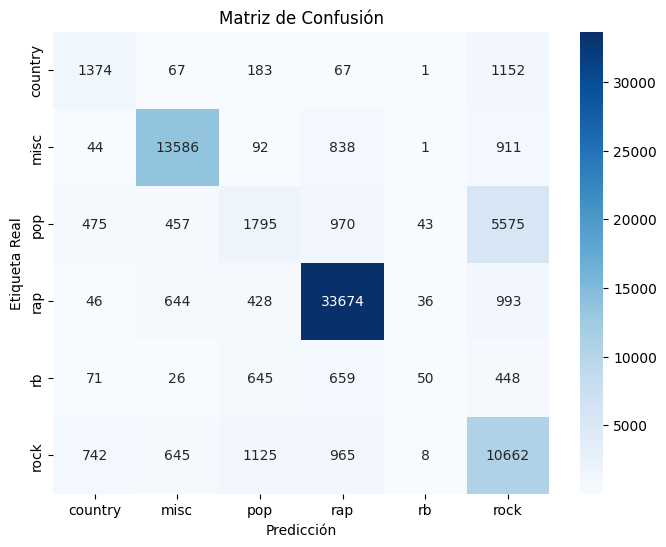

In [33]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


## Probando el modelo con la letra de una canción

Según Wikipedia, Bang Bang es una canción del genero pop o pop soul, por lo que el modelo debe de clasificarlo de manera correcta con respecto a lo que aprendió.

"Bang Bang" is a song by English singer-songwriter Jessie J, American singer-songwriter Ariana Grande, and American rapper Nicki Minaj. It was released by Lava and Republic Records on 28 July 2014 as the lead single from Jessie J's third studio album, Sweet Talker (2014).

Genre	pop
Pop soul

In [43]:
new_lyrics = """
She got a body like an hourglass
But I can give it to you all the time
She got a booty like a Cadillac
But I can send you into overdrive, oh

You've been waiting for that
Step on up, swing your bat
See, anybody could be bad to you
You need a good girl to blow your mind, yeah

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
Bang, bang, there goes your heart (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)

She might'a let you hold her hand in school
But I'ma show you how to graduate (mm-mm)
No, I don't need to hear you talk the talk
Just come and show me what your momma gave ya, baby

I heard you've got a very big (shh)
Mouth, but don't say a thing
See, anybody could be good to you
You need a bad girl to blow your mind

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
Bang, bang, there goes your heart (there goes your heart now), (I know you want it)
Back, back seat of my car (seat of my car), (I'll let you have it)
Wait a minute, let me take you there (oh), (you know what, girls?)
Wait a minute till you (oh, hey), (let me show you how to do it)

It's Myx Moscato, it's frizz in a bottle, it's Nicki Full Throttle, it's oh, oh
Swimming in The Grotto, we winning in the lotto, we dipping in the powder-blue four-door
Kitten so good, it's dripping on wood, get a ride in the engine that could go
Batman, robbin' it, bang, bang, cockin' it, Queen Nicki dominant, prominent
It's me, Jessie, and Ari, if they test me, they sorry
Ride his uh like a Harley then pull off in his Ferrari
If he hangin', we bangin', phone rangin', he slangin'
It ain't karaoke night, but get the mic, 'cause I'm singin'

Uh, B to the A to the N to the G to the (baby, baby, baby, bae, ba-baby)
Uh, B to the A to the N to the G to the, hey
See, anybody could be good to you
You need a bad girl to blow your mind, your mind (okay)
Hey

Bang, bang into the room (oh), (I know you want it)
Bang, bang all over you (I'll let you have it), (b-bang, bang, bang, bang, baby)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, yeah), (kyuh, uh-huh)
Bang, bang, there goes your heart (there goes your heart), (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (let me take you there)
Wait a minute till you (hey)

Bang, bang into the room (I know you want it)
Bang, bang all over you (I'll let you have it)
Yo, I said: Bang, bang, bang, ba-bang, bang (oh)
Bang, bang, bang, bang, ba-bang, bang (oh)
Bang, bang, there goes your heart (I know you want it)
Back, back seat of my car (I'll let you have it)
Wait a minute, let me take you there (oh)
Wait a minute till you (oh, hey)
"""

seq = tokenizer.texts_to_sequences([new_lyrics])
padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')


In [45]:
import numpy as np

pred_probs = model_to_train.predict(padded)
pred_index = np.argmax(pred_probs, axis=1)[0]
pred_label = le.inverse_transform([pred_index])[0]

print(f"Predicción de género: {pred_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Predicción de género: pop
